In [1]:
# Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import torch
from chronos import BaseChronosPipeline
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import warnings

In [2]:
# Charger le dataset
file_path = 'data/truck_sales.csv'
data = pd.read_csv(file_path)

# Afficher un aperçu des données
print("\n=== Aperçu des premières lignes ===")
print(data.head())


=== Aperçu des premières lignes ===
  Month-Year  Number_Trucks_Sold
0     03-Jan                 155
1     03-Feb                 173
2     03-Mar                 204
3     03-Apr                 219
4     03-May                 223


In [3]:
# Statistiques descriptives
print("\nStatistiques descriptives :\n", data.describe())


Statistiques descriptives :
        Number_Trucks_Sold
count          144.000000
mean           428.729167
std            188.633037
min            152.000000
25%            273.500000
50%            406.000000
75%            560.250000
max            958.000000


In [4]:
# Vérifier les valeurs manquantes
missing_values = data.isnull().sum()
print("\nValeurs manquantes :\n", missing_values)


Valeurs manquantes :
 Month-Year            0
Number_Trucks_Sold    0
dtype: int64


In [5]:
# Vérifier les types de données
print("\nTypes de données :\n", data.dtypes)


Types de données :
 Month-Year            object
Number_Trucks_Sold     int64
dtype: object


In [6]:
# Convertir la colonne 'Month-Year' en format datetime et renommer
data['Date'] = pd.to_datetime(data['Month-Year'], format='%y-%b')
data = data.rename(columns={'Number_Trucks_Sold': 'Sales'})
data = data.drop(columns=['Month-Year'])  # Supprimer l'ancienne colonne inutile

In [7]:
# Vérifier la plage de dates
print("\nPlage de dates :", data['Date'].min(), "à", data['Date'].max())


Plage de dates : 2003-01-01 00:00:00 à 2014-12-01 00:00:00


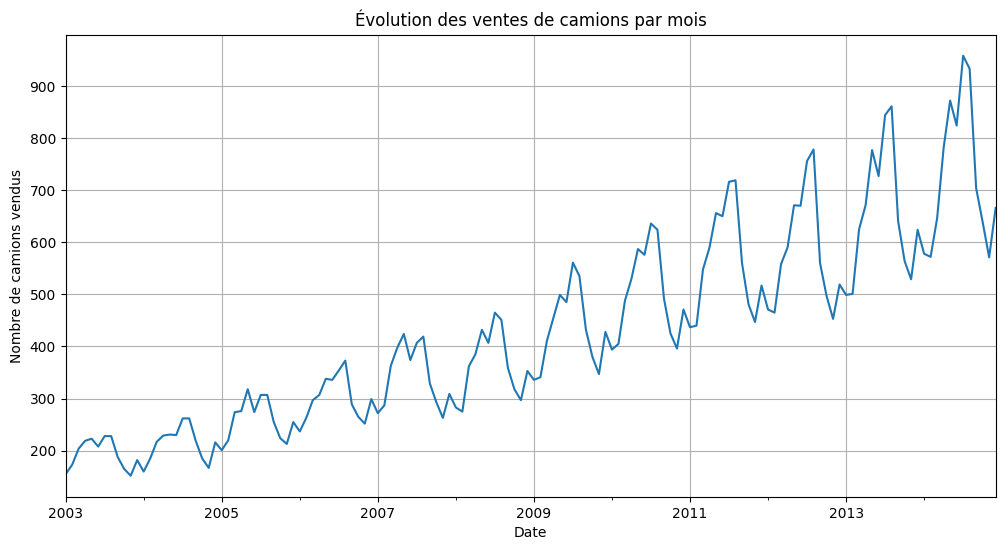

In [8]:
# Vérifier la distribution temporelle des ventes
plt.figure(figsize=(12, 6))
data.set_index('Date')['Sales'].plot()
plt.title("Évolution des ventes de camions par mois")
plt.xlabel("Date")
plt.ylabel("Nombre de camions vendus")
plt.grid()
plt.show()

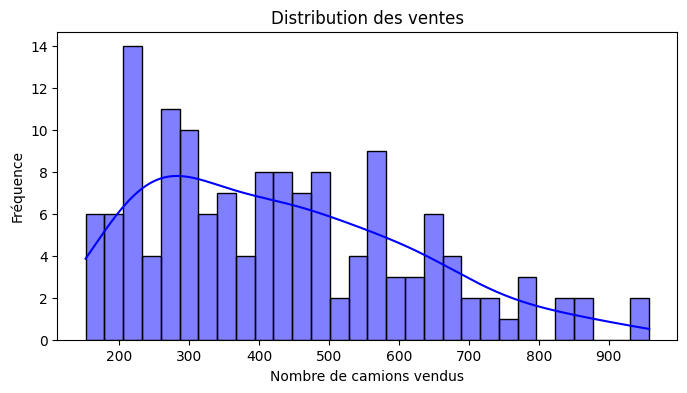

In [9]:
# Visualisation de la distribution des ventes
plt.figure(figsize=(8, 4))
sns.histplot(data['Sales'], bins=30, kde=True, color='blue')
plt.title("Distribution des ventes")
plt.xlabel("Nombre de camions vendus")
plt.ylabel("Fréquence")
plt.show()

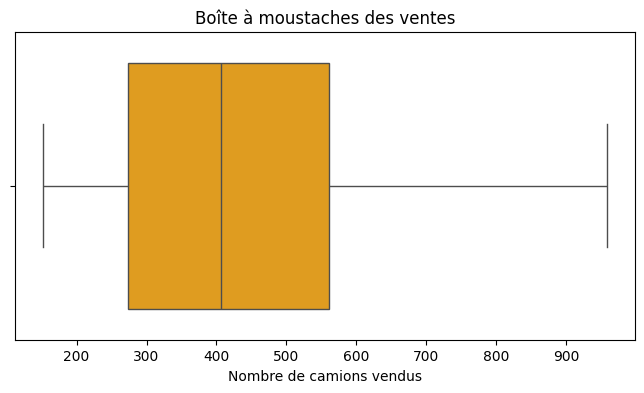

In [10]:
# Boîte à moustaches pour détecter les valeurs aberrantes
plt.figure(figsize=(8, 4))
sns.boxplot(x=data['Sales'], color='orange')
plt.title("Boîte à moustaches des ventes")
plt.xlabel("Nombre de camions vendus")
plt.show()

In [11]:
# Trier les données par date (au cas où)
data = data.sort_values(by='Date')

# Réindexer par la colonne 'Date'
data.set_index('Date', inplace=True)

# Afficher un aperçu des données transformées
print("\n=== Données après conversion et transformation ===")
print(data.head())


=== Données après conversion et transformation ===
            Sales
Date             
2003-01-01    155
2003-02-01    173
2003-03-01    204
2003-04-01    219
2003-05-01    223


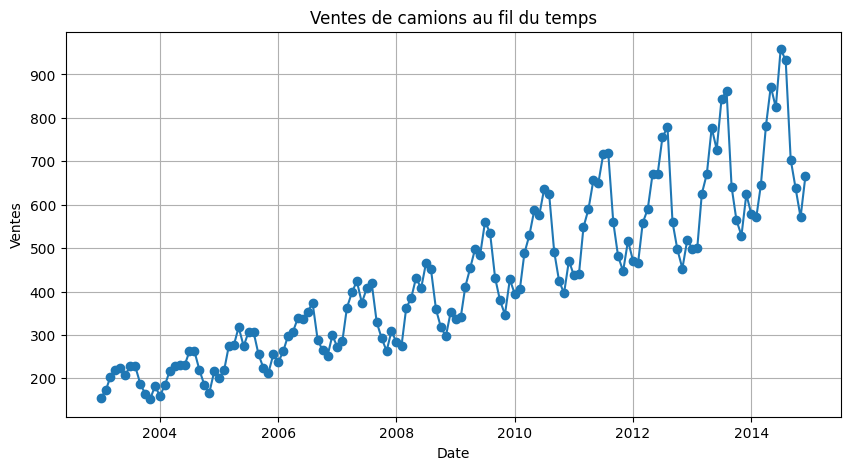

In [12]:
# Visualiser la série temporelle
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['Sales'], marker='o')
plt.title("Ventes de camions au fil du temps")
plt.xlabel("Date")
plt.ylabel("Ventes")
plt.grid()
plt.show()

In [13]:
warnings.filterwarnings("ignore")  # Ignorer les warnings pour une sortie plus propre

auto_model = auto_arima(
    data['Sales'],
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    trace=True,
    error_action='ignore',
    max_p=5, max_d=2, max_q=5,
)

# Résumé des meilleurs paramètres trouvés
print("\n=== Meilleurs paramètres ARIMA ===")
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1591.981, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1590.212, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1589.735, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1590.450, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1578.003, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1591.484, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1591.297, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1576.449, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1588.110, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1588.577, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1575.284, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1589.7

In [14]:
# split train/test
train_size = int(len(data) * 0.8)
arima_train = data.iloc[:train_size]
arima_test  = data.iloc[train_size:]

In [15]:
# Ajuster le modèle ARIMA avec les meilleurs paramètres
arima_model = auto_model.fit(arima_train['Sales'])

In [16]:
# Prédire sur l'horizon du test
arima_test_predictions = arima_model.predict(n_periods=len(arima_test))

In [17]:
# Ajouter les prédictions dans le DataFrame de test
arima_test = arima_test.copy()
arima_test['Predictions'] = arima_test_predictions

# Calcul des métriques
mae = mean_absolute_error(arima_test['Sales'], arima_test['Predictions'])
rmse = np.sqrt(mean_squared_error(arima_test['Sales'], arima_test['Predictions']))
mape = np.mean(np.abs((arima_test['Sales'] - arima_test['Predictions']) / arima_test['Sales'])) * 100

print("\n=== Métriques de performance ===")
print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")


=== Métriques de performance ===
MAE : 83.56
RMSE : 100.67
MAPE : 12.39%


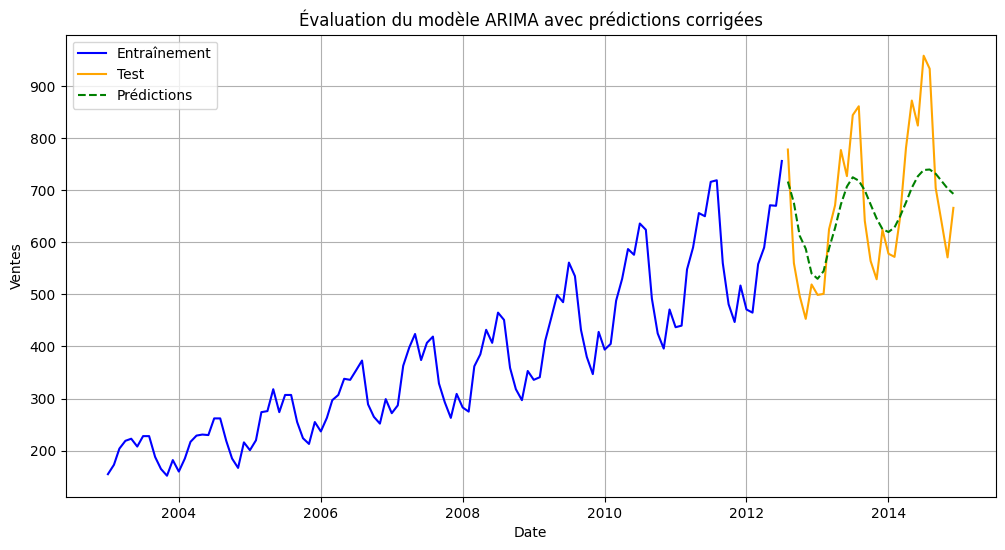

In [18]:
# Tracer le graphique avec les prédictions corrigées
plt.figure(figsize=(12, 6))
plt.plot(arima_train['Sales'], label="Entraînement", color="blue")
plt.plot(arima_test['Sales'], label="Test", color="orange")
plt.plot(arima_test['Predictions'], label="Prédictions", linestyle="--", color="green")
plt.title("Évaluation du modèle ARIMA avec prédictions corrigées")
plt.xlabel("Date")
plt.ylabel("Ventes")
plt.legend()
plt.grid()
plt.show()

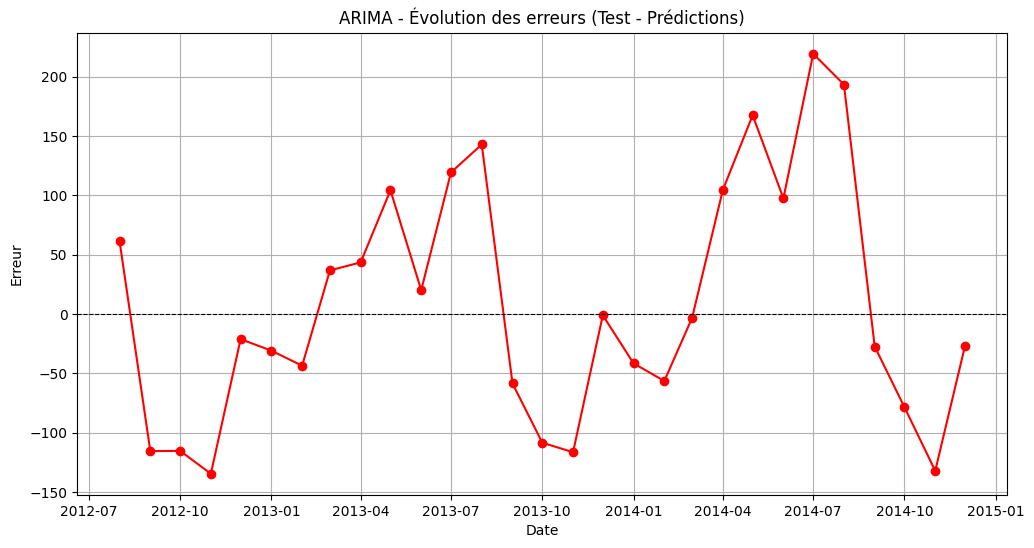

In [19]:
# Calcul des erreurs
errors = arima_test['Sales'] - arima_test['Predictions']

# Graphique linéaire des erreurs
plt.figure(figsize=(12, 6))
plt.plot(arima_test.index, errors, marker='o', linestyle='-', color='red')
plt.title("ARIMA - Évolution des erreurs (Test - Prédictions)")
plt.xlabel("Date")
plt.ylabel("Erreur")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.grid()
plt.show()

In [20]:
# Ajouter une colonne pour l'année et le trimestre
arima_test['Year'] = arima_test.index.year
arima_test['Quarter'] = arima_test.index.quarter

# Calculer les erreurs moyennes par année et par trimestre
error_by_year = arima_test.groupby('Year').apply(
    lambda x: np.mean(x['Sales'] - x['Predictions'])
)
error_by_quarter = arima_test.groupby(['Year', 'Quarter']).apply(
    lambda x: np.mean(x['Sales'] - x['Predictions'])
)

# Afficher les erreurs moyennes par année
print("\n=== Erreurs moyennes par année ===")
print(error_by_year)


=== Erreurs moyennes par année ===
Year
2012   -65.108492
2013     8.928508
2014    34.615506
dtype: float64


In [21]:
# Afficher les erreurs moyennes par trimestre
print("\n=== Erreurs moyennes par trimestre ===")
print(error_by_quarter)


=== Erreurs moyennes par trimestre ===
Year  Quarter
2012  3          -27.081036
      4          -90.460129
2013  1          -12.638819
      2           55.928725
      3           67.832489
      4          -75.408362
2014  1          -33.816900
      2          123.157119
      3          128.406600
      4          -79.284795
dtype: float64


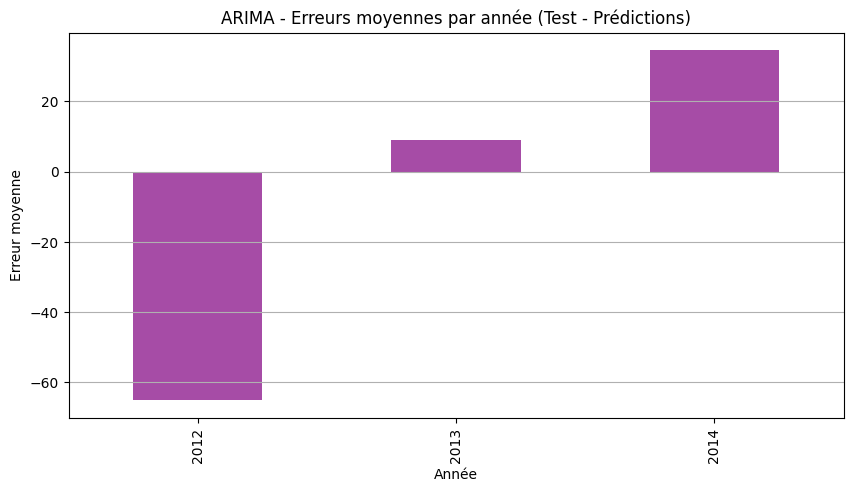

In [22]:
# Visualiser les erreurs moyennes par année
plt.figure(figsize=(10, 5))
error_by_year.plot(kind='bar', color='purple', alpha=0.7)
plt.title("ARIMA - Erreurs moyennes par année (Test - Prédictions)")
plt.xlabel("Année")
plt.ylabel("Erreur moyenne")
plt.grid(axis='y')
plt.show()

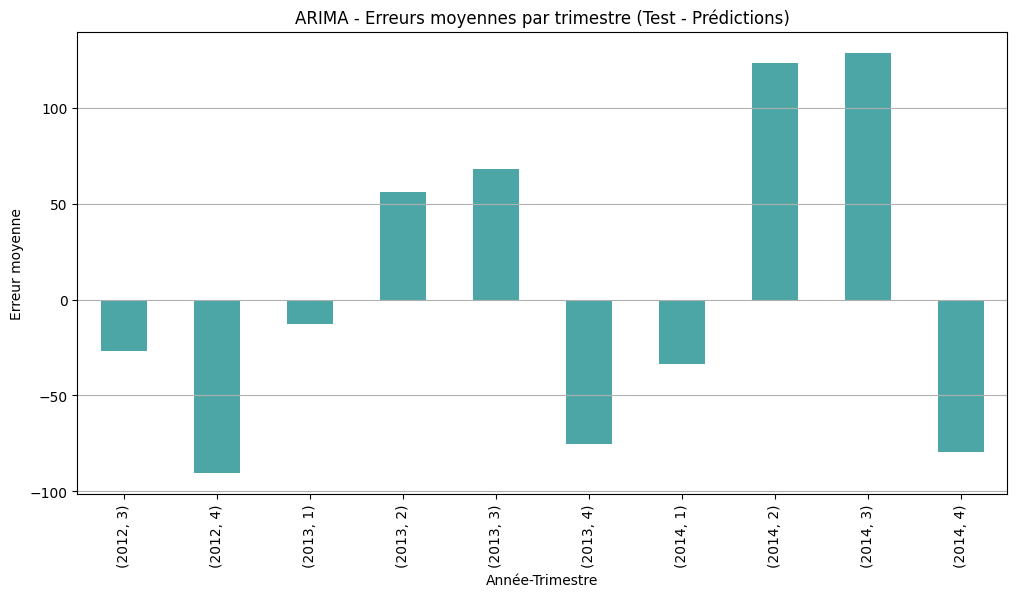

In [23]:
# Visualiser les erreurs moyennes par trimestre
plt.figure(figsize=(12, 6))
error_by_quarter.plot(kind='bar', color='teal', alpha=0.7)
plt.title("ARIMA - Erreurs moyennes par trimestre (Test - Prédictions)")
plt.xlabel("Année-Trimestre")
plt.ylabel("Erreur moyenne")
plt.grid(axis='y')
plt.show()

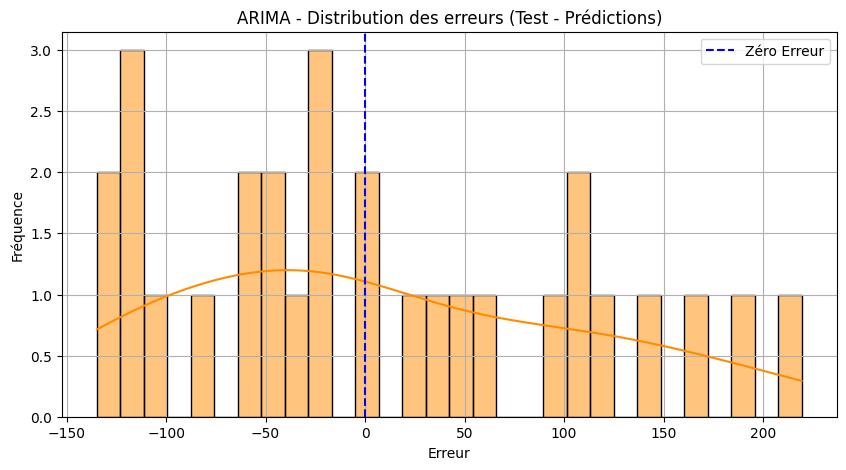

In [24]:
# Calculer les erreurs
errors = arima_test['Sales'] - arima_test['Predictions']

# Visualiser la distribution des erreurs
plt.figure(figsize=(10, 5))
sns.histplot(errors, kde=True, bins=30, color="darkorange")
plt.title("ARIMA - Distribution des erreurs (Test - Prédictions)")
plt.xlabel("Erreur")
plt.ylabel("Fréquence")
plt.axvline(0, color='blue', linestyle='--', label='Zéro Erreur')
plt.legend()
plt.grid()
plt.show()

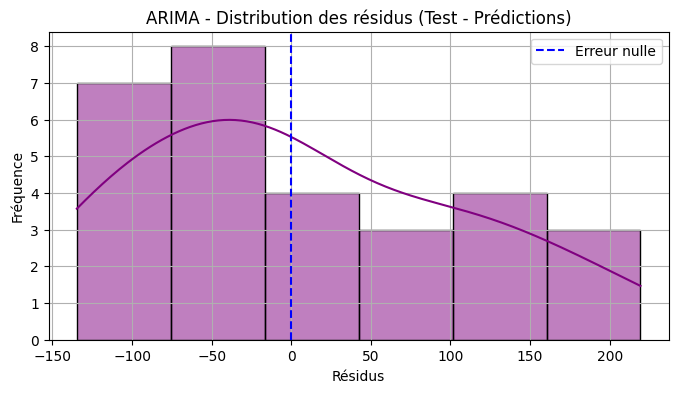

In [25]:
# Visualiser les résidus pour détecter des biais
arima_test['Residuals'] = arima_test['Sales'] - arima_test['Predictions']

# Distribution des résidus
plt.figure(figsize=(8, 4))
sns.histplot(arima_test['Residuals'], kde=True, color="purple")
plt.axvline(0, color="blue", linestyle="--", label="Erreur nulle")
plt.title("ARIMA - Distribution des résidus (Test - Prédictions)")
plt.xlabel("Résidus")
plt.ylabel("Fréquence")
plt.legend()
plt.grid()
plt.show()

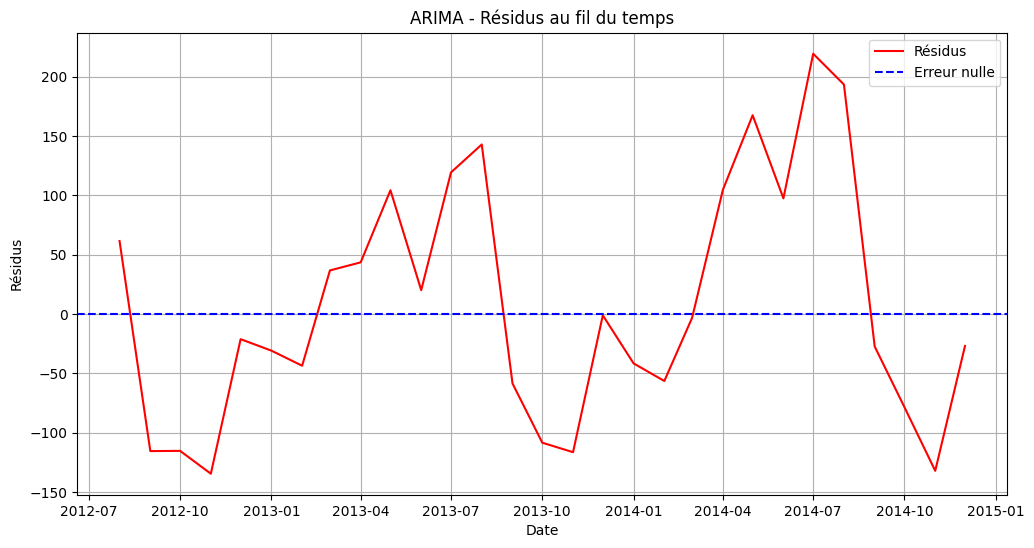

In [26]:
# Résidus en série temporelle
plt.figure(figsize=(12, 6))
plt.plot(arima_test.index, arima_test['Residuals'], color="red", label="Résidus")
plt.axhline(0, color="blue", linestyle="--", label="Erreur nulle")
plt.title("ARIMA - Résidus au fil du temps")
plt.xlabel("Date")
plt.ylabel("Résidus")
plt.legend()
plt.grid()
plt.show()

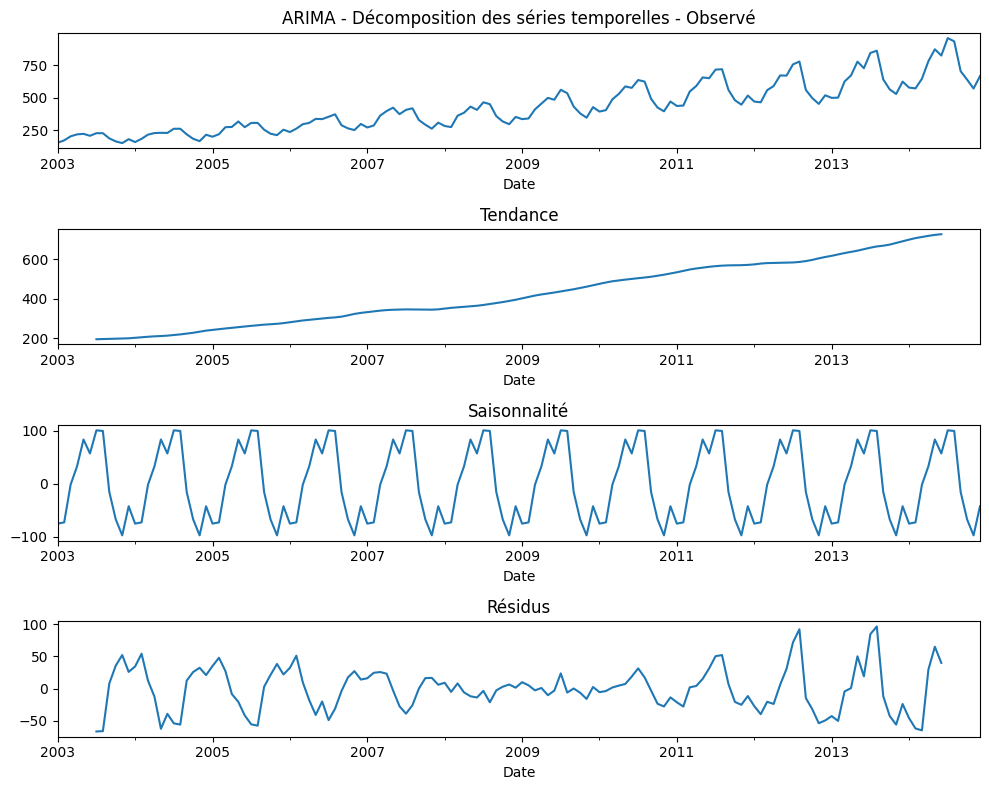

In [27]:
# Décomposer la série temporelle
decomposition = seasonal_decompose(data['Sales'], model='additive', period=12)

# Ajuster la taille de la figure
fig, axes = plt.subplots(4, 1, figsize=(10, 8))  # 4 lignes, 1 colonne

# Tracer les composantes
decomposition.observed.plot(ax=axes[0], title="ARIMA - Décomposition des séries temporelles - Observé")
decomposition.trend.plot(ax=axes[1], title="Tendance")
decomposition.seasonal.plot(ax=axes[2], title="Saisonnalité")
decomposition.resid.plot(ax=axes[3], title="Résidus")

# Appliquer une mise en page propre pour éviter les chevauchements
plt.tight_layout()
plt.show()

In [28]:
# Charger les données d'origine et les préparer
file_path = 'data/truck_sales.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Month-Year'], format='%y-%b')
data = data.rename(columns={'Number_Trucks_Sold': 'Sales'})
data = data.sort_values(by='Date').set_index('Date')

In [29]:
# Diviser les données en ensembles d'entraînement et de test
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

In [30]:
warnings.filterwarnings("ignore")

# Configurer le pipeline Chronos
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-base",
    device_map="cpu",  # Utiliser le CPU
    torch_dtype=torch.float32  # Format des données
)

In [31]:
# Préparer les données pour Chronos
context = torch.tensor(train_data['Sales'].values, dtype=torch.float32)
prediction_length = len(test_data)

In [32]:
# Faire des prédictions avec Chronos
quantiles, mean = pipeline.predict_quantiles(
    context=context,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9]
)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


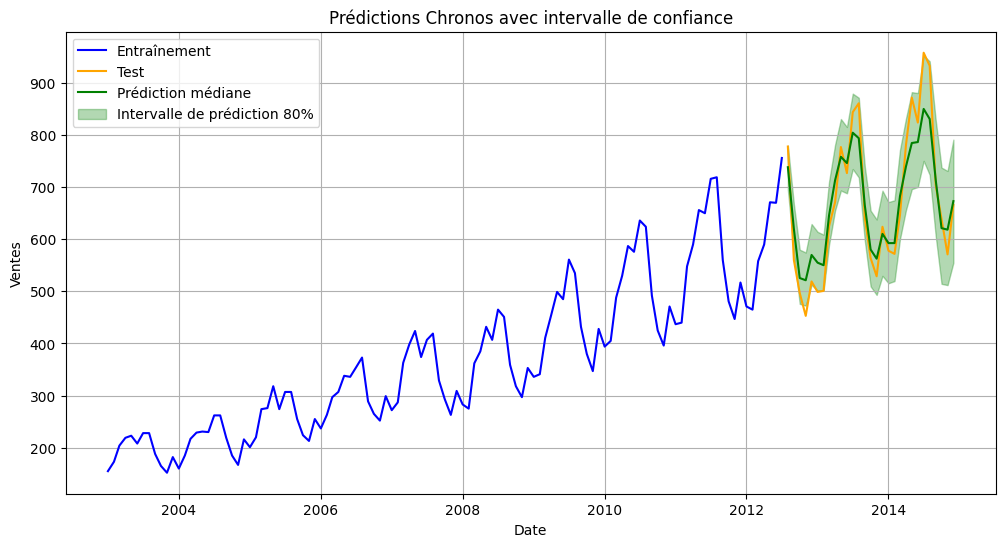

In [33]:
# Visualiser les résultats avec les prédictions
forecast_index = test_data.index  # Utiliser les index temporels du jeu de test
low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Sales'], label="Entraînement", color="blue")
plt.plot(test_data.index, test_data['Sales'], label="Test", color="orange")
plt.plot(forecast_index, median, label="Prédiction médiane", color="green")
plt.fill_between(
    forecast_index,
    low, high,
    color="green", alpha=0.3, label="Intervalle de prédiction 80%"
)
plt.title("Prédictions Chronos avec intervalle de confiance")
plt.xlabel("Date")
plt.ylabel("Ventes")
plt.legend()
plt.grid()
plt.show()

In [34]:
median_np = median.numpy()

# Calcul des erreurs (différence entre les prédictions médianes et les valeurs réelles)
errors = test_data['Sales'].values - median_np

# Calcul des métriques
mae = mean_absolute_error(test_data['Sales'].values, median_np)
mse = mean_squared_error(test_data['Sales'].values, median_np)  # Calcul du MSE
rmse = np.sqrt(mse)  # Calcul du RMSE à partir du MSE
mape = (abs(errors) / test_data['Sales'].values).mean() * 100

# Afficher les métriques
print("\n=== Métriques de performance Chronos-Bolt-Base ===")
print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")


=== Métriques de performance Chronos-Bolt-Base ===
MAE : 40.63
RMSE : 48.22
MAPE : 6.11%


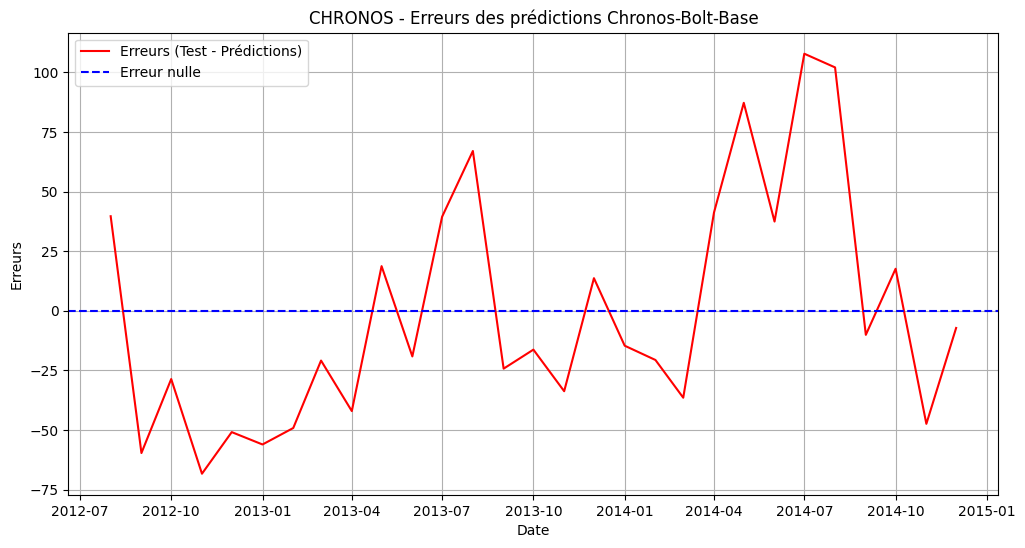

In [35]:
# Afficher un graphique des erreurs
plt.figure(figsize=(12, 6))
plt.plot(forecast_index, errors, label="Erreurs (Test - Prédictions)", color="red")
plt.axhline(0, linestyle="--", color="blue", label="Erreur nulle")
plt.title("CHRONOS - Erreurs des prédictions Chronos-Bolt-Base")
plt.xlabel("Date")
plt.ylabel("Erreurs")
plt.legend()
plt.grid()
plt.show()

In [36]:
# Ajouter les erreurs dans les données de test
test_data['Errors'] = test_data['Sales'] - median_np

# Erreurs moyennes par année
error_by_year = test_data['Errors'].groupby(test_data.index.year).mean()
print("\n=== Erreurs moyennes par année ===")
print(error_by_year)


=== Erreurs moyennes par année ===
Date
2012   -33.590405
2013   -10.233739
2014    21.424555
Name: Errors, dtype: float64


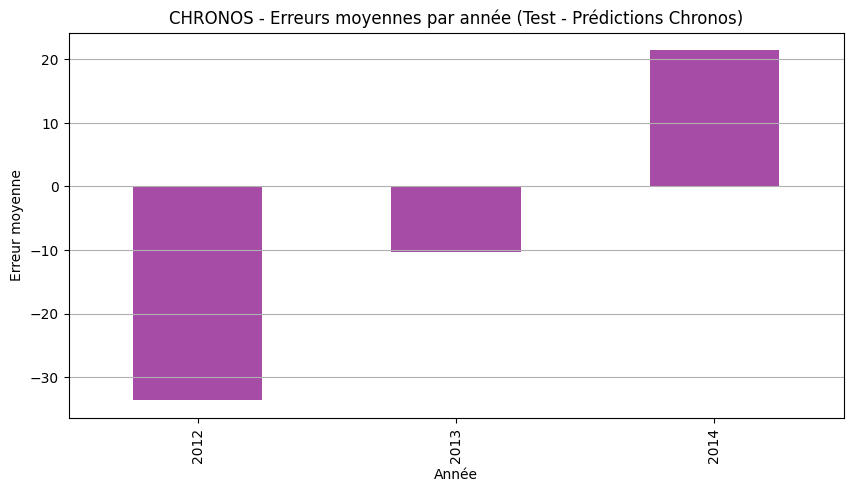

In [37]:
# Visualiser les erreurs moyennes par année
plt.figure(figsize=(10, 5))
error_by_year.plot(kind='bar', color='purple', alpha=0.7)
plt.title("CHRONOS - Erreurs moyennes par année (Test - Prédictions Chronos)")
plt.xlabel("Année")
plt.ylabel("Erreur moyenne")
plt.grid(axis='y')
plt.show()

In [38]:
# Erreurs moyennes par trimestre
test_data['Year'] = test_data.index.year
test_data['Quarter'] = test_data.index.quarter
error_by_quarter = test_data['Errors'].groupby([test_data['Year'], test_data['Quarter']]).mean()
print("\n=== Erreurs moyennes par trimestre ===")
print(error_by_quarter)


=== Erreurs moyennes par trimestre ===
Year  Quarter
2012  3         -10.008057
      4         -49.311971
2013  1         -42.061584
      2         -14.167684
      3          27.419149
      4         -12.124837
2014  1         -23.926961
      2          55.325684
      3          66.638590
      4         -12.339091
Name: Errors, dtype: float64


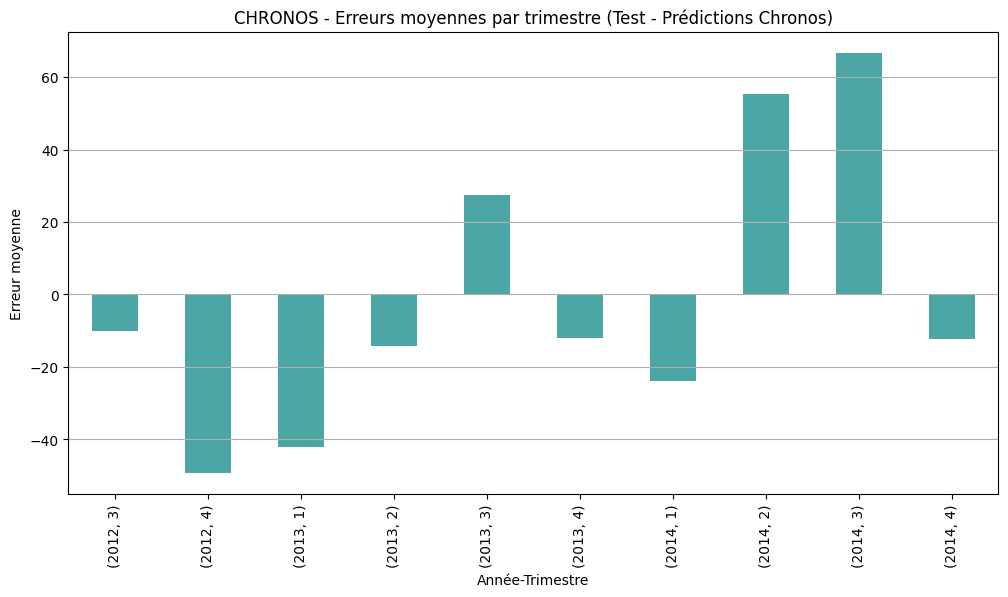

In [39]:
# Visualiser les erreurs moyennes par trimestre
plt.figure(figsize=(12, 6))
error_by_quarter.plot(kind='bar', color='teal', alpha=0.7)
plt.title("CHRONOS - Erreurs moyennes par trimestre (Test - Prédictions Chronos)")
plt.xlabel("Année-Trimestre")
plt.ylabel("Erreur moyenne")
plt.grid(axis='y')
plt.show()

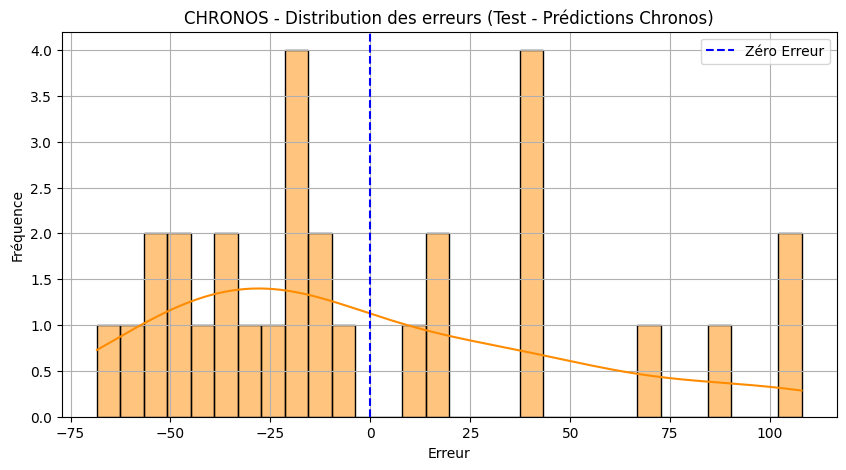

In [40]:
# Visualiser la distribution des erreurs
plt.figure(figsize=(10, 5))
sns.histplot(test_data['Errors'], kde=True, bins=30, color="darkorange")
plt.title("CHRONOS - Distribution des erreurs (Test - Prédictions Chronos)")
plt.xlabel("Erreur")
plt.ylabel("Fréquence")
plt.axvline(0, color='blue', linestyle='--', label='Zéro Erreur')
plt.legend()
plt.grid()
plt.show()

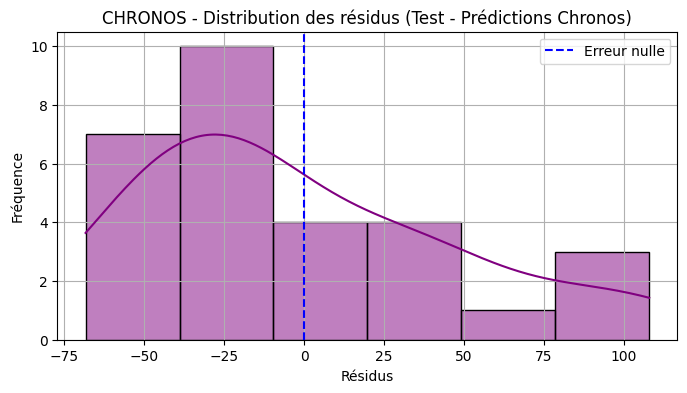

In [41]:
# Distribution des résidus
plt.figure(figsize=(8, 4))
sns.histplot(test_data['Errors'], kde=True, color="purple")
plt.axvline(0, color="blue", linestyle="--", label="Erreur nulle")
plt.title("CHRONOS - Distribution des résidus (Test - Prédictions Chronos)")
plt.xlabel("Résidus")
plt.ylabel("Fréquence")
plt.legend()
plt.grid()
plt.show()

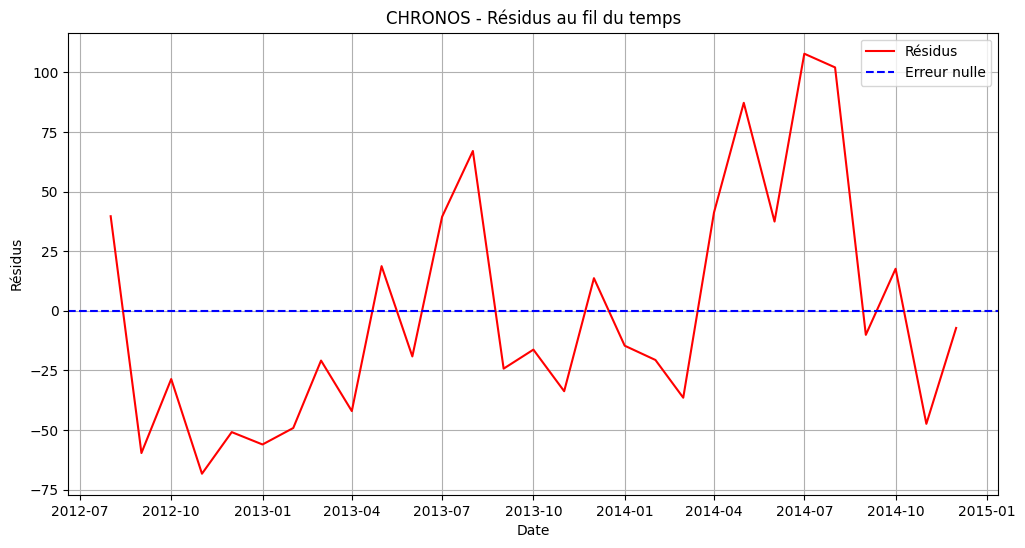

In [42]:
# Résidus en série temporelle
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Errors'], color="red", label="Résidus")
plt.axhline(0, color="blue", linestyle="--", label="Erreur nulle")
plt.title("CHRONOS - Résidus au fil du temps")
plt.xlabel("Date")
plt.ylabel("Résidus")
plt.legend()
plt.grid()
plt.show()

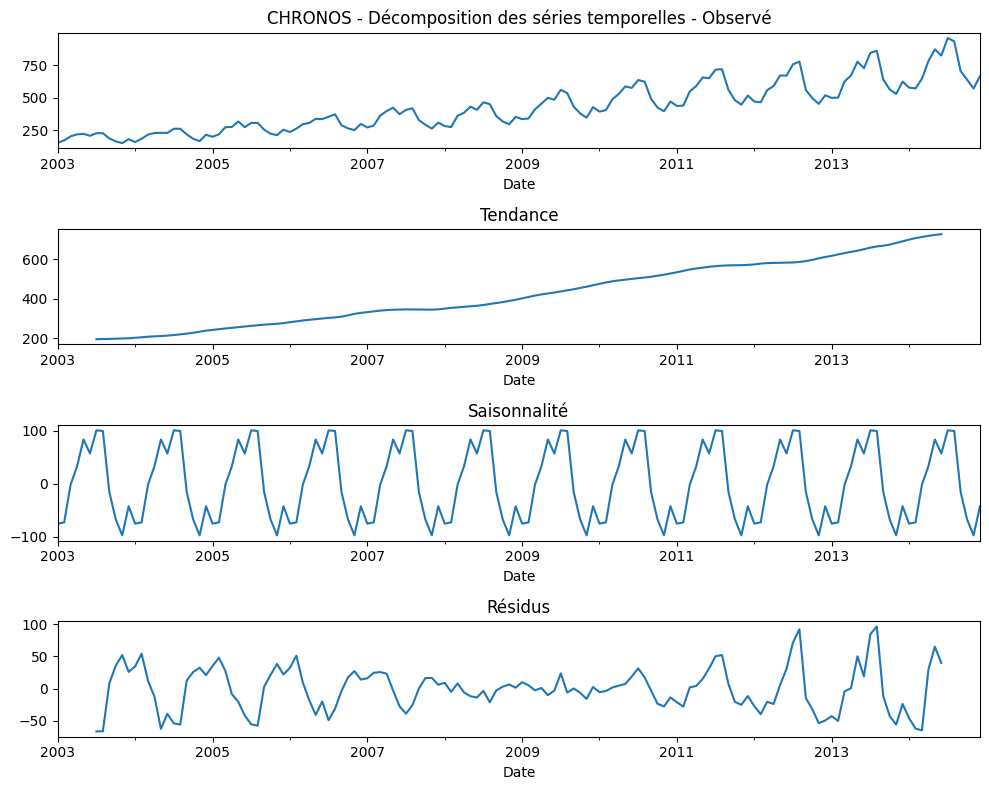

In [43]:
# Décomposer la série temporelle
decomposition = seasonal_decompose(data['Sales'], model='additive', period=12)

# Ajuster la taille de la figure
fig, axes = plt.subplots(4, 1, figsize=(10, 8))  # 4 lignes, 1 colonne

# Tracer les composantes
decomposition.observed.plot(ax=axes[0], title="CHRONOS - Décomposition des séries temporelles - Observé")
decomposition.trend.plot(ax=axes[1], title="Tendance")
decomposition.seasonal.plot(ax=axes[2], title="Saisonnalité")
decomposition.resid.plot(ax=axes[3], title="Résidus")

# Appliquer une mise en page propre pour éviter les chevauchements
plt.tight_layout()
plt.show()

In [2]:
# Charger le dataset
file_path = 'data/truck_sales.csv'
data = pd.read_csv(file_path)

In [3]:
# Convertir la colonne 'Month-Year' en format datetime et renommer immédiatement en 'timestamp'
data['timestamp'] = pd.to_datetime(data['Month-Year'], format='%y-%b')
data = data.rename(columns={'Number_Trucks_Sold': 'target'})
data = data.drop(columns=['Month-Year'])  # Supprimer l'ancienne colonne inutile

# Ajouter une colonne `item_id` unique (puisque c'est une seule série)
data['item_id'] = 'truck_sales'  # Un identifiant unique pour toute la série

# Trier les données par date
data = data.sort_values(by='timestamp')

# Convertir en TimeSeriesDataFrame
data = TimeSeriesDataFrame.from_data_frame(data)
data.head()

target
item_id     timestamp         
truck_sales 2003-01-01     155
            2003-02-01     173
            2003-03-01     204
            2003-04-01     219
            2003-05-01     223

In [14]:
prediction_length = 29
train_data, test_data = data.train_test_split(prediction_length)

In [15]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    eval_metric='MAPE',
)

In [16]:
# Entraîner le prédicteur (avec ARIMA et Chronos-Bolt-Base par exemple)
predictor.fit(
    train_data=train_data,
    presets='best_quality',
    hyperparameters={
        'ARIMA': {},
        "Chronos": [
            {"model_path": "bolt_base", "ag_args": {"name_suffix": "ZeroShot"}},
        ]
    }
)

Beginning AutoGluon training...
AutoGluon will save models to 'e:\Openclassroom\AI_Engineer\Projet_09\work_folder\AutogluonModels\ag-20250206_113225'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.9.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          24
GPU Count:          0
Memory Avail:       44.57 GB / 63.14 GB (70.6%)
Disk Space Avail:   1960.38 GB / 5589.01 GB (35.1%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'hyperparameters': {'ARIMA': {},
                     'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'}]},
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 29,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selecti

In [17]:
# Afficher le leaderboard des modèles entraînés
leaderboard = predictor.leaderboard()
print("\n=== Leaderboard ===")
leaderboard


=== Leaderboard ===


,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.075744,1.115046,0.160022,3
1,ChronosZeroShot[bolt_base],-0.075744,1.115046,1.155763,1
2,ARIMA,-0.216220,2.047711,2.151368,2


In [18]:
metrics = predictor.evaluate(test_data, model="ARIMA", metrics=["MAPE", "MAE", "MSE"])
print("Métriques personnalisées sur les données de test avec ARIMA:")
print(metrics)

Métriques personnalisées sur les données de test avec ARIMA:
{'MAPE': -0.2562892450583346, 'MAE': -150.25517755989534, 'MSE': -30165.524465052666}


In [19]:
metrics = predictor.evaluate(test_data, model="ChronosZeroShot[bolt_base]", metrics=["MAPE", "MAE", "MSE"])
print("Métriques personnalisées sur les données de test avec Chronos:")
print(metrics)

Métriques personnalisées sur les données de test avec Chronos:
{'MAPE': -0.06113388101450622, 'MAE': -40.626902613146555, 'MSE': -2325.3242278173566}


In [20]:
# Résultats des métriques obtenus dynamiquement
metrics_arima = predictor.evaluate(test_data, model="ARIMA", metrics=["MAPE", "MAE", "MSE"])
metrics_chronos = predictor.evaluate(test_data, model="ChronosZeroShot[bolt_base]", metrics=["MAPE", "MAE", "MSE"])

# Ajouter une clé "Model" pour identifier chaque modèle
metrics_arima["Model"] = "ARIMA"
metrics_chronos["Model"] = "ChronosZeroShot[bolt_base]"

# Créer un DataFrame à partir des résultats
results_df = pd.DataFrame([metrics_arima, metrics_chronos])

# Réorganiser les colonnes pour mettre "Model" en premier
results_df = results_df[["Model", "MAPE", "MAE", "MSE"]]

# Convertir MAPE en pourcentage et arrondir à 2 décimales
results_df["MAPE"] = (results_df["MAPE"].abs() * 100).round(2)

# Renommer la colonne pour indiquer que c'est un pourcentage
results_df = results_df.rename(columns={"MAPE": "MAPE (%)"})

# Rendre MAE et MSE positifs et arrondis pour plus de clarté
results_df["MAE"] = results_df["MAE"].abs().round(2)
results_df["MSE"] = results_df["MSE"].abs().round(2)

# Afficher le DataFrame
results_df

,Model,MAPE (%),MAE,MSE
0,ARIMA,25.63,150.26,30165.52
1,ChronosZeroShot[bolt_base],6.11,40.63,2325.32


In [21]:
# Prédictions pour ARIMA spécifiquement
predictions_arima = predictor.predict(train_data, model="ARIMA")

# Prédictions pour Chronos (déjà le meilleur modèle par défaut)
predictions_chronos = predictor.predict(train_data, model='ChronosZeroShot[bolt_base]')

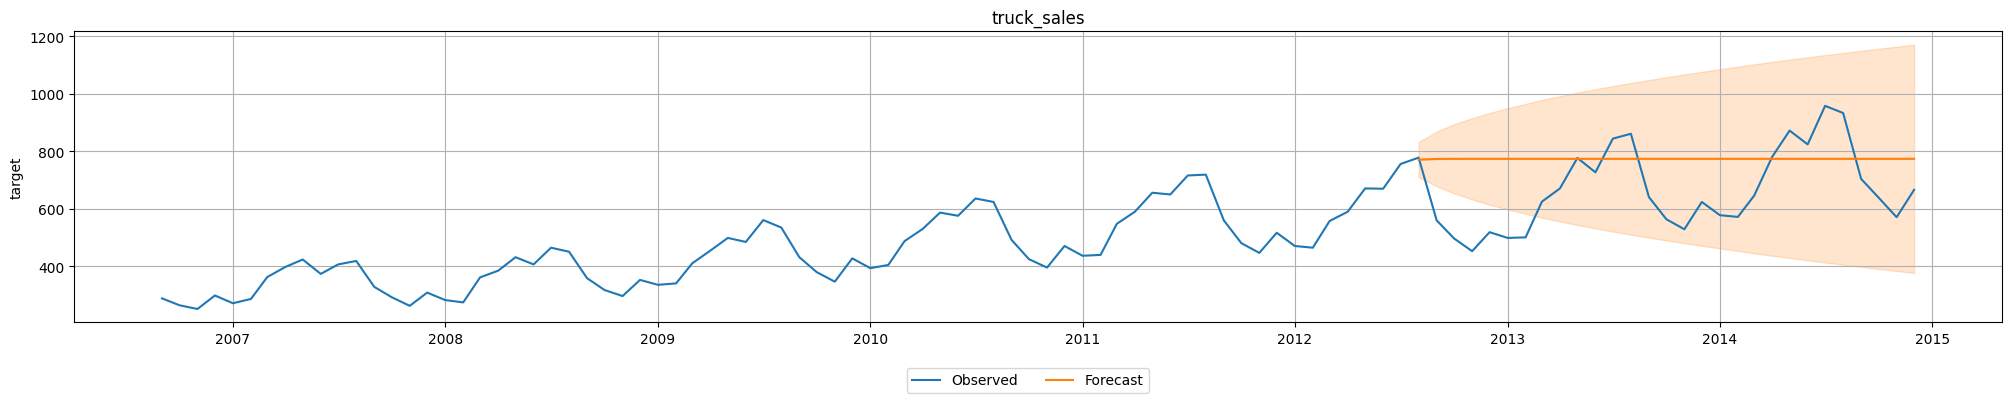

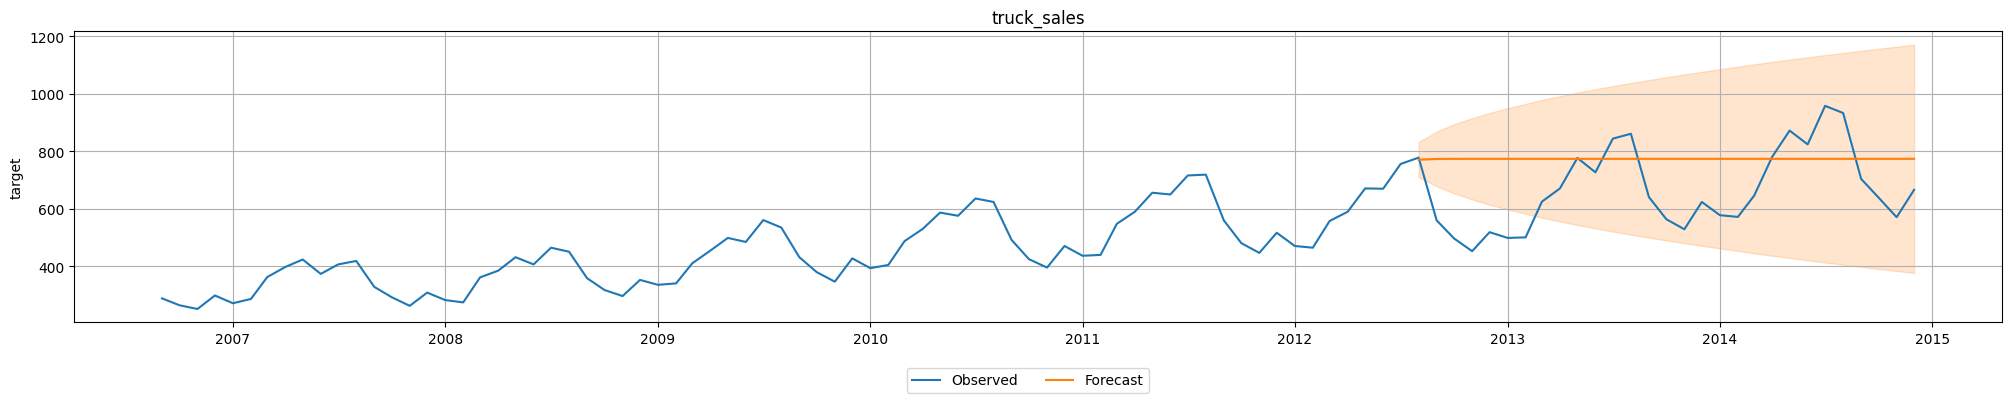

In [22]:
predictor.plot(
    data=data,
    predictions=predictions_arima,
    item_ids=["truck_sales"],
    max_history_length=100,
)

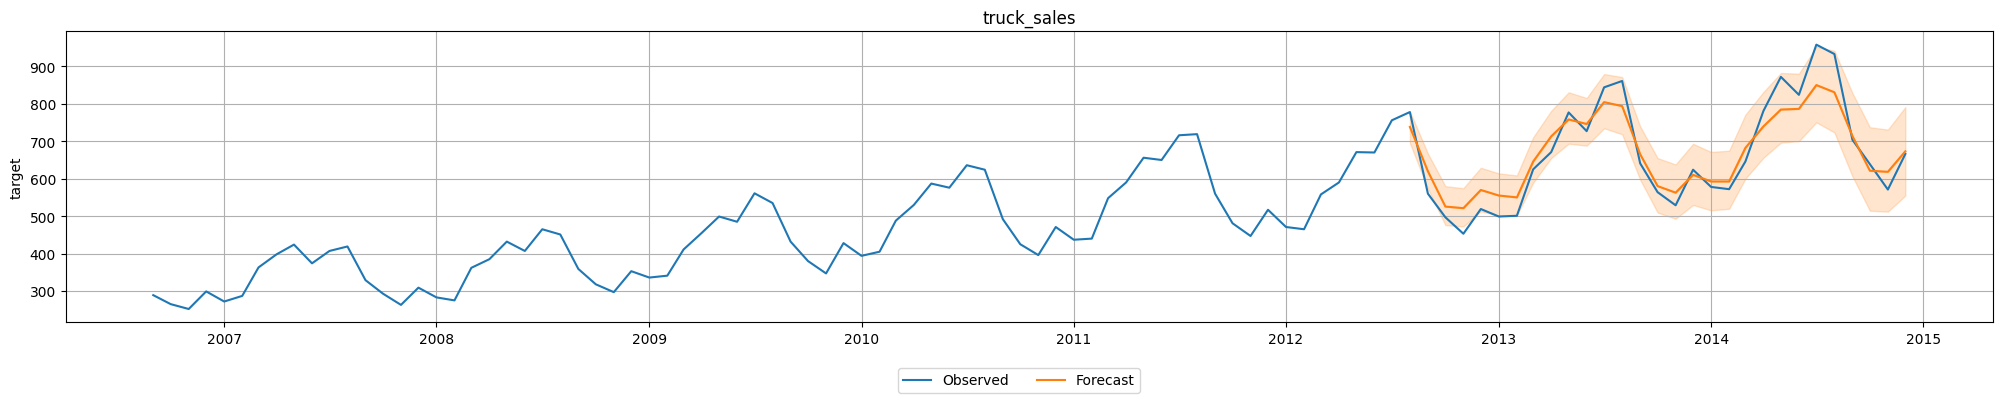

In [23]:
predictor.plot(
    data=test_data,
    predictions=predictions_chronos,
    item_ids=["truck_sales"],
    max_history_length=100,
)

In [4]:
predictor=TimeSeriesPredictor(prediction_length=24).fit(data, presets='bolt_base')

Beginning AutoGluon training...
AutoGluon will save models to 'e:\Openclassroom\AI_Engineer\Projet_09\work_folder\AutogluonModels\ag-20250207_135231'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.9.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          24
GPU Count:          0
Memory Avail:       49.74 GB / 63.14 GB (78.8%)
Disk Space Avail:   1960.36 GB / 5589.01 GB (35.1%)
Setting presets to: bolt_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 144

	6.69    s     = Training runtime
Training complete. Models trained: ['Chronos[bolt_base]']
Total runtime: 6.81 s
Best model: Chronos[bolt_base]


In [5]:
predictions = predictor.predict(data)

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]


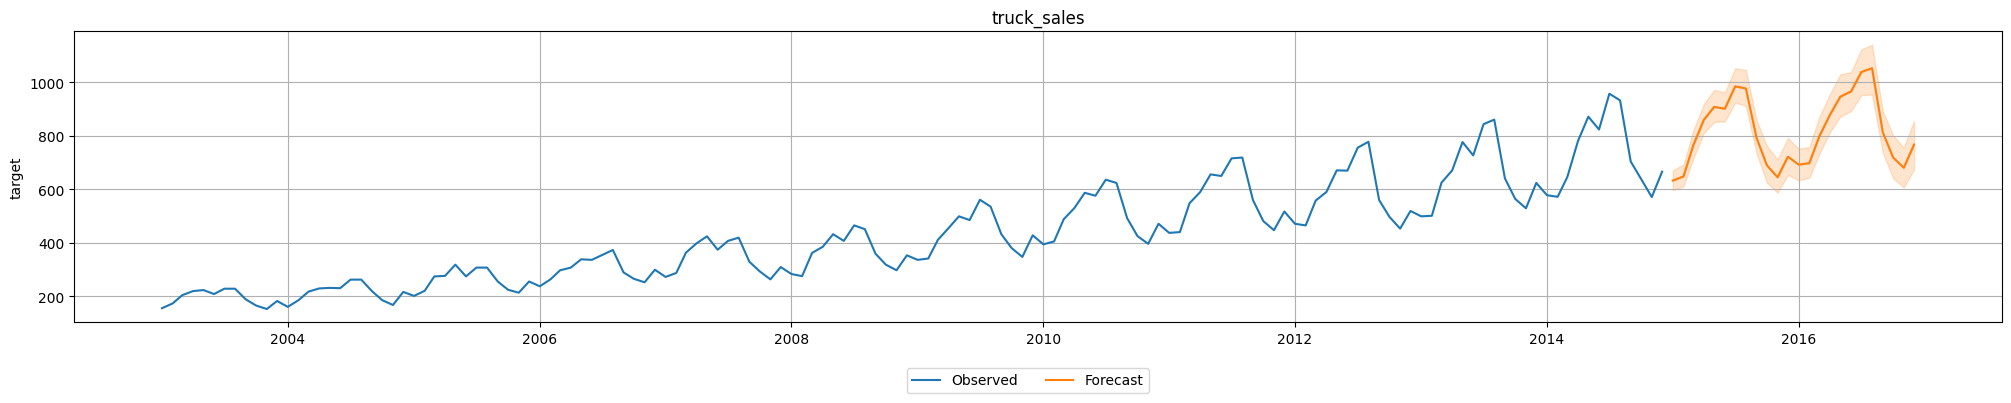

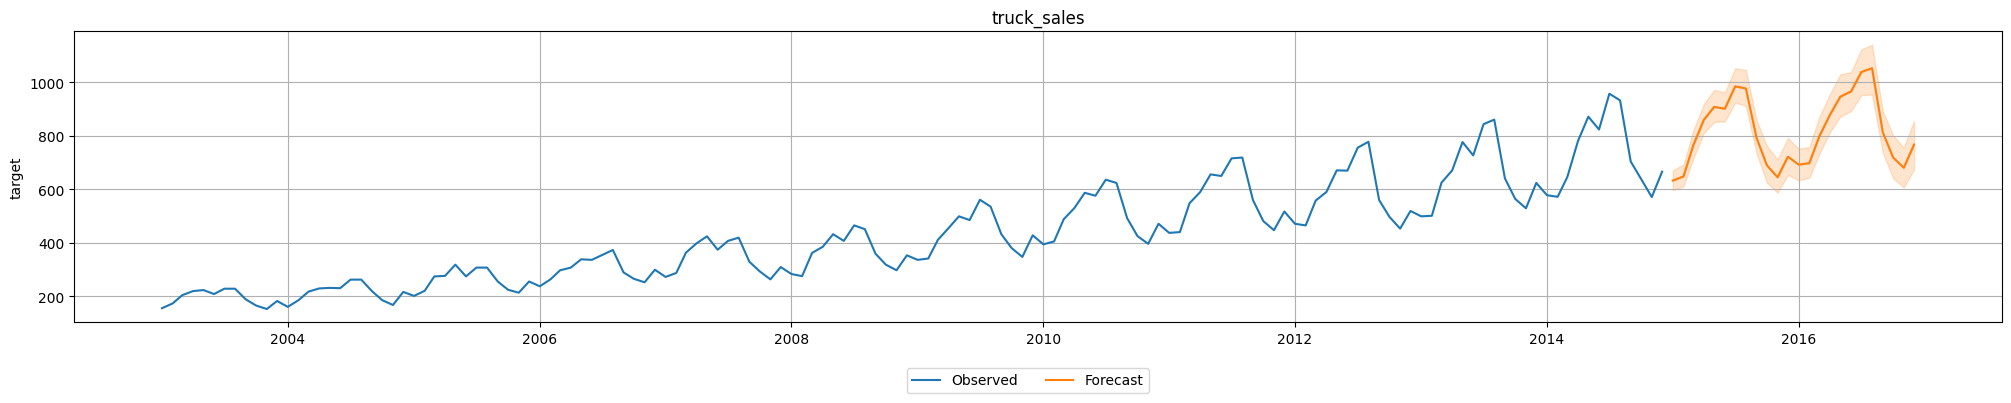

In [6]:
predictor.plot(data, predictions=predictions)